## Doublet Removal - Pseudo Doublets

In [5]:
import scanpy as sc
import numpy as np
import pandas as pd
from matplotlib import rcParams
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
import os

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

# data files are in the filtered matrix folder from CellRanger which has been renamed to the sample name
sample_name = r'sc85_1g' #r'sc70_1' #r'sc72_1'
data_path = r"../raw_data/"
data_files_path = data_path + sample_name + r""

results_path = 'results/'
results_file = results_path + sample_name + '-db.h5ad'  # the file that will store the analysis results
metrics_file = results_path + sample_name + '_db_metrics.csv'  # the file that will store the metrics
# make results folder if it doesn't exist
if not os.path.exists(results_path):
    os.makedirs(results_path, exist_ok=False)

scanpy==1.10.3 anndata==0.11.0 umap==0.5.7 numpy==1.26.4 scipy==1.14.1 pandas==2.2.3 scikit-learn==1.5.2 statsmodels==0.14.4 igraph==0.11.8 louvain==0.8.2 pynndescent==0.5.13


#### Setup R environment

In [6]:
import os
os.environ['R_HOME'] = r"C:\Program Files\R\R-4.4.2"  
import anndata2ri # order matters, comes after defining 'R_HOME
import logging
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro
rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%reload_ext rpy2.ipython

C:\Users\leeh1\AppData\Local\Temp\ipykernel_24912\364680306.py:9: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [7]:
%%R
.libPaths(c("C:/Users/leeh1/AppData/Local/R/win-library/4.4", .libPaths()))
library(Seurat)
library(scater)
library(scDblFinder)
library(BiocParallel)

#### Load data

Read in count data into an [`AnnData`](https://anndata.readthedocs.io/en/latest/anndata.AnnData.html) object.  
The matrix.mtx file contains a sparse matrix of the counts.  
Barcodes file contains the sample names in the format: AAACCCAAGACCATAA-1  
Features file contains the gene id in the format: ENSMUSG00000051951, Xkr4, Gene Expression

The number of counts per cell will be relatively low since only UMIs are counted by Cellranger

In [8]:
adata = sc.read_10x_mtx(
    data_files_path,              # the directory with the `.mtx` file
    var_names='gene_symbols',     # use gene symbols for the variable names (variables-axis index)
    cache=True)                   # write a cache file for faster subsequent reading

# adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`
print('Data matrix is sparse:', scipy.sparse.issparse(adata.X))
print()

# make the obs names unique by adding the sample name
adata.obs_names = [g.split("-")[0] + '_' + sample_name for g in adata.obs_names]
print(adata.obs_names[0:2])
print()
print('Number of cells =', f"{adata.n_obs:,.0f}")
print('Number of genes =', f"{adata.n_vars:,.0f}")
print('Number of counts =', f"{adata.X.sum():,.0f}")
print('Mean counts per cell =', f"{adata.X.sum()/adata.n_obs:,.0f}")
adata

... writing an h5ad cache file to speedup reading next time
Data matrix is sparse: True

Index(['AAACAGCCAACCGCCA_sc85_1g', 'AAACAGCCAAGGTATA_sc85_1g'], dtype='object')

Number of cells = 15,830
Number of genes = 36,530
Number of counts = 13,291,714
Mean counts per cell = 840


AnnData object with n_obs × n_vars = 15830 × 36530
    var: 'gene_ids', 'feature_types'

In [9]:
n_cells = adata.n_obs
n_genes = adata.n_vars
n_counts = adata.X.sum()    
counts_per_cell = round(n_counts / n_cells)

df_metrics = pd.DataFrame([n_cells, n_genes, n_counts, counts_per_cell], \
                  index = ['Number of cells', 'Number of genes', 'Number of counts','Mean counts per cell']).T
df_metrics.iloc[:, 1:] = df_metrics.iloc[:,1:].applymap('{:,.0f}'.format)
df_metrics.index = [sample_name]
df_metrics

C:\Users\leeh1\AppData\Local\Temp\ipykernel_24912\1815972615.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_metrics.iloc[:, 1:] = df_metrics.iloc[:,1:].applymap('{:,.0f}'.format)
C:\Users\leeh1\AppData\Local\Temp\ipykernel_24912\1815972615.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0    36,530
Name: Number of genes, dtype: object' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_metrics.iloc[:, 1:] = df_metrics.iloc[:,1:].applymap('{:,.0f}'.format)
C:\Users\leeh1\AppData\Local\Temp\ipykernel_24912\1815972615.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0    13,291,714
Name: Number of counts, dtype: object' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_metrics.iloc[:, 1:] = df_metrics.iloc[:,1

,Number of cells,Number of genes,Number of counts,Mean counts per cell
sc85_1g,15830.0,"36,530","13,291,714",840


### Detect doublets
Remove "empty" genes before doublet detection.

In [10]:
sc.pp.filter_genes(adata, min_cells=1)
df_metrics['Filter genes:'] = ' '
df_metrics['Number of genes removed'] = n_genes - adata.n_vars

filtered out 11479 genes that are detected in less than 1 cells


In [11]:
data_mat = adata.X.T                 # transform data matrix
doublet_ratio = n_cells/1000*0.008   # calculate multiplet rate based on 10x formula
print('multiplet rate = %4.1f' %(doublet_ratio*100), '%')

multiplet rate = 12.7 %


In [12]:
%%R -i data_mat -i doublet_ratio -o doublet_score -o doublet_class

set.seed(123)
sce = scDblFinder(SingleCellExperiment(list(counts=data_mat),), dbr=doublet_ratio)
doublet_score = sce$scDblFinder.score
doublet_class = sce$scDblFinder.class

Creating ~12664 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 2878 cells excluded from training.
iter=1, 3021 cells excluded from training.
iter=2, 3031 cells excluded from training.
Threshold found:0.48
2666 (16.8%) doublets called


In [13]:
doublets = [1.0 if x == 'doublet' else 0 for x in doublet_class]
adata.obs["scDblFinder_score"] = doublet_score
adata.obs["scDblFinder_class"] = doublet_class
adata.obs["doublet"] = doublets

In [14]:
doublet_percentage = sum(doublets)/adata.n_obs*100
print('Doublet percentage = %4.1f' %(doublet_percentage))
df_metrics['Doublet removal:'] = ' '
df_metrics['Doublet percentage'] =  doublet_percentage

adata.obs.scDblFinder_class.value_counts()

Doublet percentage = 16.8


scDblFinder_class
singlet    13164
doublet     2666
Name: count, dtype: int64

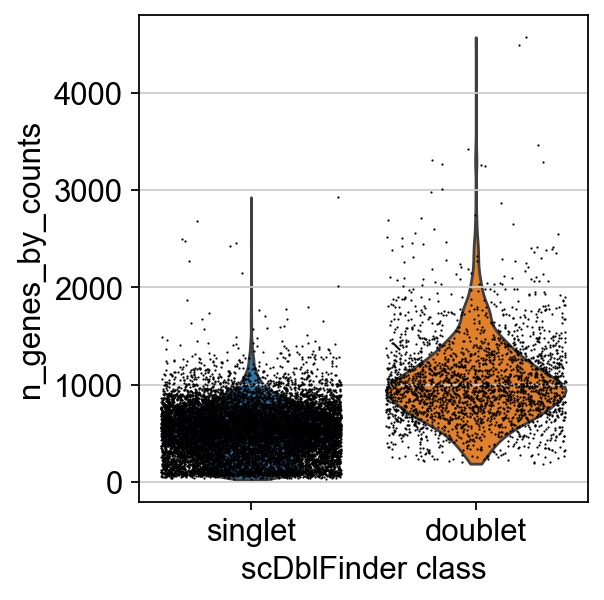

In [15]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, 'n_genes_by_counts',jitter=0.4, groupby = 'scDblFinder_class')

In [16]:
num_before = adata.n_obs
singlets = adata.obs["scDblFinder_class"] == 'singlet'
num_after = adata[singlets].n_obs
n_genes = adata[singlets].n_vars
n_counts = adata[singlets].X.sum()    
counts_per_cell = round(n_counts / n_cells)

print('Number of cells before doublet removal =', num_before)
print('Number of cells after doublet removal =', num_after)
print('Number of cells removed =', num_before - num_after)
removed_percentage = (num_before - num_after)/num_before*100
print('Percentage of cells removed = %4.1f' %(removed_percentage))
n_counts = adata.X.sum()  
print('Number of counts =', f"{n_counts:,.0f}")
print('Mean counts per cell =', f"{counts_per_cell:,.0f}")

df_metrics['Number of cells removed'] =  num_before - num_after
df_metrics['After doublet removal:'] = ' '
df_metrics['Number of cells -db'] = num_after
df_metrics['Number of genes -db'] = n_genes
df_metrics['Number of counts -db'] = n_counts
df_metrics['Mean counts per cell -db'] = counts_per_cell

Number of cells before doublet removal = 15830
Number of cells after doublet removal = 13164
Number of cells removed = 2666
Percentage of cells removed = 16.8
Number of counts = 13,291,714
Mean counts per cell = 585


### Isolating Singlets

In [25]:
bdata = adata[singlets].copy()
print(bdata)

AnnData object with n_obs × n_vars = 13164 × 25051
    obs: 'scDblFinder_score', 'scDblFinder_class', 'doublet', 'n_genes_by_counts', 'total_counts'
    var: 'gene_ids', 'feature_types', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'scDblFinder_class_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'


### UMAP
Visualize the data before and after doublet removal.

In [18]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:16)


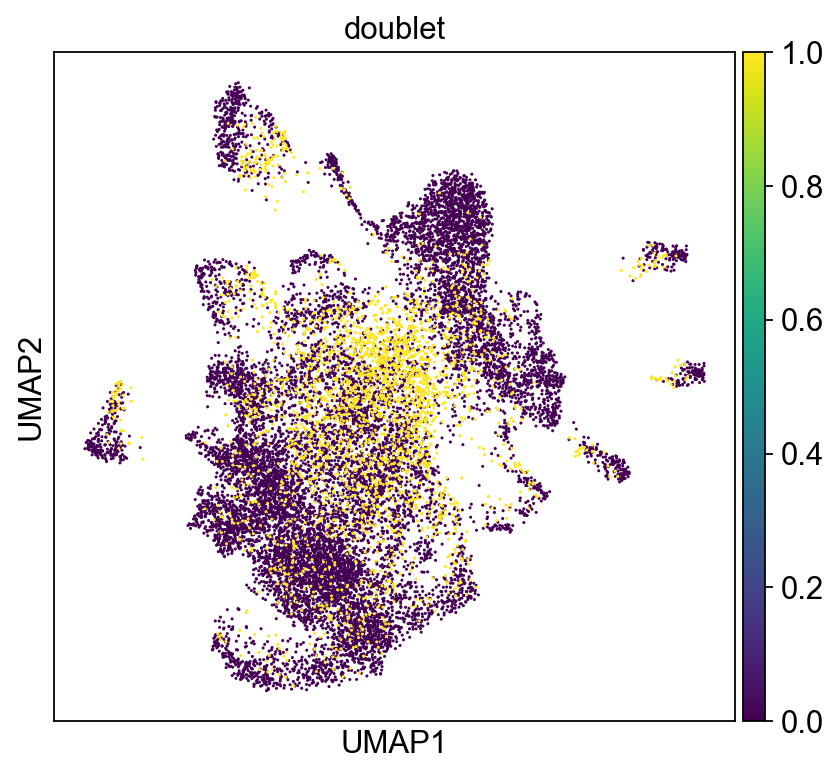

In [19]:
rcParams['figure.figsize'] = 6, 5.5
sc.pl.umap(adata, color=['doublet'])

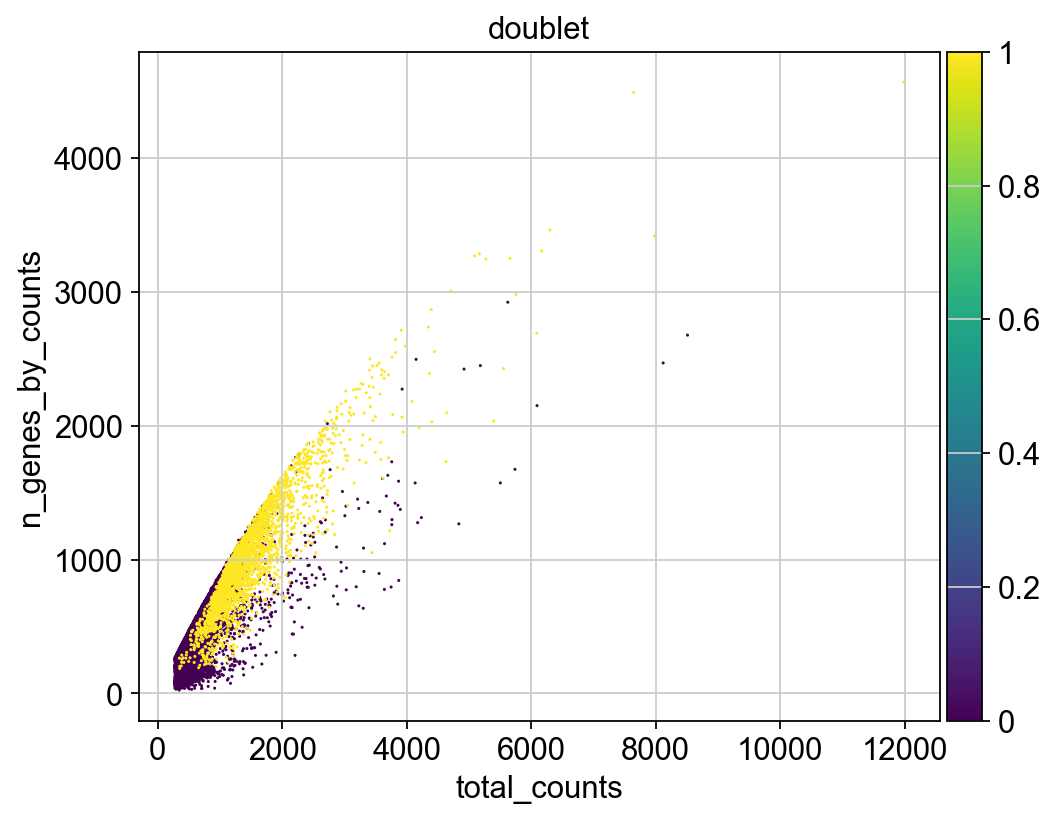

In [20]:
sc.pl.scatter(adata, 'total_counts', 'n_genes_by_counts', color='doublet')

#### Cleaning up `bdata`

In [26]:
print(bdata.shape)
print(bdata.obs)
print(bdata.var_names)

(13164, 25051)
                          scDblFinder_score scDblFinder_class  doublet  \
AAACAGCCAACCGCCA_sc85_1g           0.003629           singlet      0.0   
AAACAGCCAAGGTATA_sc85_1g           0.394116           singlet      0.0   
AAACAGCCAATAGCAA_sc85_1g           0.000046           singlet      0.0   
AAACAGCCATGAATCT_sc85_1g           0.190027           singlet      0.0   
AAACATGCAAGTGAAC_sc85_1g           0.000593           singlet      0.0   
...                                     ...               ...      ...   
TTTGTTGGTTAAGTGT_sc85_1g           0.000028           singlet      0.0   
TTTGTTGGTTACGCGG_sc85_1g           0.000216           singlet      0.0   
TTTGTTGGTTAGGATT_sc85_1g           0.000906           singlet      0.0   
TTTGTTGGTTGCCTCA_sc85_1g           0.224797           singlet      0.0   
TTTGTTGGTTGGCGTG_sc85_1g           0.000338           singlet      0.0   

                          n_genes_by_counts  total_counts  
AAACAGCCAACCGCCA_sc85_1g            

In [27]:
bdata.obs.drop(columns=["scDblFinder_score"], inplace=True)
bdata.obs.drop(columns=["scDblFinder_class"], inplace=True)
bdata.obs.drop(columns=["n_genes_by_counts"], inplace=True)
bdata.obs.drop(columns=["total_counts"], inplace=True)
bdata.obs.drop(columns=["doublet"], inplace=True)

print(bdata.obs)

Empty DataFrame
Columns: []
Index: [AAACAGCCAACCGCCA_sc85_1g, AAACAGCCAAGGTATA_sc85_1g, AAACAGCCAATAGCAA_sc85_1g, AAACAGCCATGAATCT_sc85_1g, AAACATGCAAGTGAAC_sc85_1g, AAACATGCACCGTTCC_sc85_1g, AAACATGCACTAAATC_sc85_1g, AAACATGCAGGCCAAA_sc85_1g, AAACATGCATGATTGT_sc85_1g, AAACCAACAATAGCAA_sc85_1g, AAACCAACACAGAACG_sc85_1g, AAACCAACAGCAAGAT_sc85_1g, AAACCAACAGCAAGTG_sc85_1g, AAACCAACAGCTAACC_sc85_1g, AAACCAACAGGTTATT_sc85_1g, AAACCAACATTGTTGG_sc85_1g, AAACCGAAGATTCCTT_sc85_1g, AAACCGAAGCAAGATG_sc85_1g, AAACCGAAGCAGCTAT_sc85_1g, AAACCGAAGCATGAAG_sc85_1g, AAACCGAAGGACAATG_sc85_1g, AAACCGAAGGACTTAC_sc85_1g, AAACCGAAGGTCAAAG_sc85_1g, AAACCGAAGTAACGGA_sc85_1g, AAACCGAAGTTCCCAC_sc85_1g, AAACCGCGTAGCTAGC_sc85_1g, AAACCGCGTAGGTTGC_sc85_1g, AAACCGCGTCTTACTA_sc85_1g, AAACCGCGTTAATCGG_sc85_1g, AAACCGCGTTAGTTGG_sc85_1g, AAACCGGCAACATAAG_sc85_1g, AAACCGGCAAGGTGCA_sc85_1g, AAACCGGCAGCTCATA_sc85_1g, AAACCGGCATTGTCAG_sc85_1g, AAACCGGCATTGTCCT_sc85_1g, AAACGCGCAAAGGCCA_sc85_1g, AAACGCGCAGGAACTG_sc85_1g, AA

In [28]:
print(bdata.X)

<Compressed Sparse Column sparse matrix of dtype 'float32'
	with 6810735 stored elements and shape (13164, 25051)>
  Coords	Values
  (1213, 0)	0.7252199053764343
  (5403, 0)	0.5554749965667725
  (5451, 0)	0.4361676275730133
  (7302, 0)	0.5185462236404419
  (7455, 0)	0.6318713426589966
  (8931, 0)	0.7822877168655396
  (9437, 0)	0.5956829190254211
  (10390, 0)	0.5946680903434753
  (7157, 1)	0.55024254322052
  (9135, 2)	0.7530362606048584
  (9836, 3)	0.5997779965400696
  (12531, 4)	0.6267483234405518
  (15, 5)	0.8795453906059265
  (121, 5)	0.54007488489151
  (266, 5)	0.8615896105766296
  (547, 5)	0.7665108442306519
  (1019, 5)	0.7639459371566772
  (1137, 5)	0.8309487104415894
  (1315, 5)	0.6044548153877258
  (1587, 5)	0.9770779609680176
  (1748, 5)	0.6118811368942261
  (2196, 5)	0.6594695448875427
  (2797, 5)	0.4846401512622833
  (3024, 5)	0.608675479888916
  (3059, 5)	0.5847126245498657
  :	:
  (5446, 25050)	0.6748849153518677
  (5605, 25050)	0.5896471738815308
  (5634, 25050)	1.07418775

### Rerun scDblFinder

In [29]:
print('Data matrix is sparse:', scipy.sparse.issparse(bdata.X))
print()

# make the obs names unique by adding the sample name
bdata.obs_names = [g.split("-")[0] + '_' + sample_name for g in bdata.obs_names]
print(bdata.obs_names[0:2])
print()
print('Number of cells =', f"{bdata.n_obs:,.0f}")
print('Number of genes =', f"{bdata.n_vars:,.0f}")
print('Number of counts =', f"{bdata.X.sum():,.0f}")
print('Mean counts per cell =', f"{bdata.X.sum()/adata.n_obs:,.0f}")
adata

Data matrix is sparse: True

Index(['AAACAGCCAACCGCCA_sc85_1g_sc85_1g', 'AAACAGCCAAGGTATA_sc85_1g_sc85_1g'], dtype='object')

Number of cells = 13,164
Number of genes = 25,051
Number of counts = 5,148,383
Mean counts per cell = 325


AnnData object with n_obs × n_vars = 15830 × 25051
    obs: 'scDblFinder_score', 'scDblFinder_class', 'doublet', 'n_genes_by_counts', 'total_counts'
    var: 'gene_ids', 'feature_types', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'scDblFinder_class_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [30]:
n_cells = bdata.n_obs
n_genes = bdata.n_vars
n_counts = bdata.X.sum()    
counts_per_cell = round(n_counts / n_cells)

df_metrics = pd.DataFrame([n_cells, n_genes, n_counts, counts_per_cell], \
                  index = ['Number of cells', 'Number of genes', 'Number of counts','Mean counts per cell']).T
df_metrics.iloc[:, 1:] = df_metrics.iloc[:,1:].applymap('{:,.0f}'.format)
df_metrics.index = [sample_name]
df_metrics

C:\Users\leeh1\AppData\Local\Temp\ipykernel_24912\2166053342.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_metrics.iloc[:, 1:] = df_metrics.iloc[:,1:].applymap('{:,.0f}'.format)
C:\Users\leeh1\AppData\Local\Temp\ipykernel_24912\2166053342.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0    25,051
Name: Number of genes, dtype: object' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_metrics.iloc[:, 1:] = df_metrics.iloc[:,1:].applymap('{:,.0f}'.format)
C:\Users\leeh1\AppData\Local\Temp\ipykernel_24912\2166053342.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0    5,148,383
Name: Number of counts, dtype: object' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_metrics.iloc[:, 1:] = df_metrics.iloc[:,1:

,Number of cells,Number of genes,Number of counts,Mean counts per cell
sc85_1g,13164.0,"25,051","5,148,383",391


In [31]:
sc.pp.filter_genes(bdata, min_cells=1)
df_metrics['Filter genes:'] = ' '
df_metrics['Number of genes removed'] = n_genes - bdata.n_vars

filtered out 490 genes that are detected in less than 1 cells


In [32]:
data_mat = bdata.X.T                 # transform data matrix
doublet_ratio = n_cells/1000*0.008   # calculate multiplet rate based on 10x formula
print('multiplet rate = %4.1f' %(doublet_ratio*100), '%')

multiplet rate = 10.5 %


In [33]:
%%R -i data_mat -i doublet_ratio -o doublet_score -o doublet_class

set.seed(123)
sce = scDblFinder(SingleCellExperiment(list(counts=data_mat),), dbr=doublet_ratio)
doublet_score = sce$scDblFinder.score
doublet_class = sce$scDblFinder.class

Creating ~10532 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 1154 cells excluded from training.
iter=1, 675 cells excluded from training.
iter=2, 671 cells excluded from training.
Threshold found:0.067
621 (4.7%) doublets called
In addition: Warning message:
In .checkSCE(sce) :
  Some cells in `sce` have an extremely low read counts; note that these could trigger errors and might best be filtered out


In [35]:
doublets = [1.0 if x == 'doublet' else 0 for x in doublet_class]
bdata.obs["scDblFinder_score"] = doublet_score
bdata.obs["scDblFinder_class"] = doublet_class
bdata.obs["doublet"] = doublets

In [36]:
doublet_percentage = sum(doublets)/bdata.n_obs*100
print('Doublet percentage = %4.1f' %(doublet_percentage))
df_metrics['Doublet removal:'] = ' '
df_metrics['Doublet percentage'] =  doublet_percentage

bdata.obs.scDblFinder_class.value_counts()

Doublet percentage =  4.7


scDblFinder_class
singlet    12543
doublet      621
Name: count, dtype: int64

In [38]:
num_before = bdata.n_obs
singlets = bdata.obs["scDblFinder_class"] == 'singlet'
num_after = bdata[singlets].n_obs
n_genes = bdata[singlets].n_vars
n_counts = bdata[singlets].X.sum()    
counts_per_cell = round(n_counts / n_cells)

print('Number of cells before doublet removal =', num_before)
print('Number of cells after doublet removal =', num_after)
print('Number of cells removed =', num_before - num_after)
removed_percentage = (num_before - num_after)/num_before*100
print('Percentage of cells removed = %4.1f' %(removed_percentage))
n_counts = bdata.X.sum()  
print('Number of counts =', f"{n_counts:,.0f}")
print('Mean counts per cell =', f"{counts_per_cell:,.0f}")

df_metrics['Number of cells removed'] =  num_before - num_after
df_metrics['After doublet removal:'] = ' '
df_metrics['Number of cells -db'] = num_after
df_metrics['Number of genes -db'] = n_genes
df_metrics['Number of counts -db'] = n_counts
df_metrics['Mean counts per cell -db'] = counts_per_cell

Number of cells before doublet removal = 13164
Number of cells after doublet removal = 12543
Number of cells removed = 621
Percentage of cells removed =  4.7
Number of counts = 5,148,383
Mean counts per cell = 376


### UMAP
Visualize the data before and after doublet removal.

In [39]:
sc.pp.normalize_total(bdata)
sc.pp.log1p(bdata)
sc.pp.highly_variable_genes(bdata)
sc.tl.pca(bdata)
sc.pp.neighbors(bdata)
sc.tl.umap(bdata)

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:10)


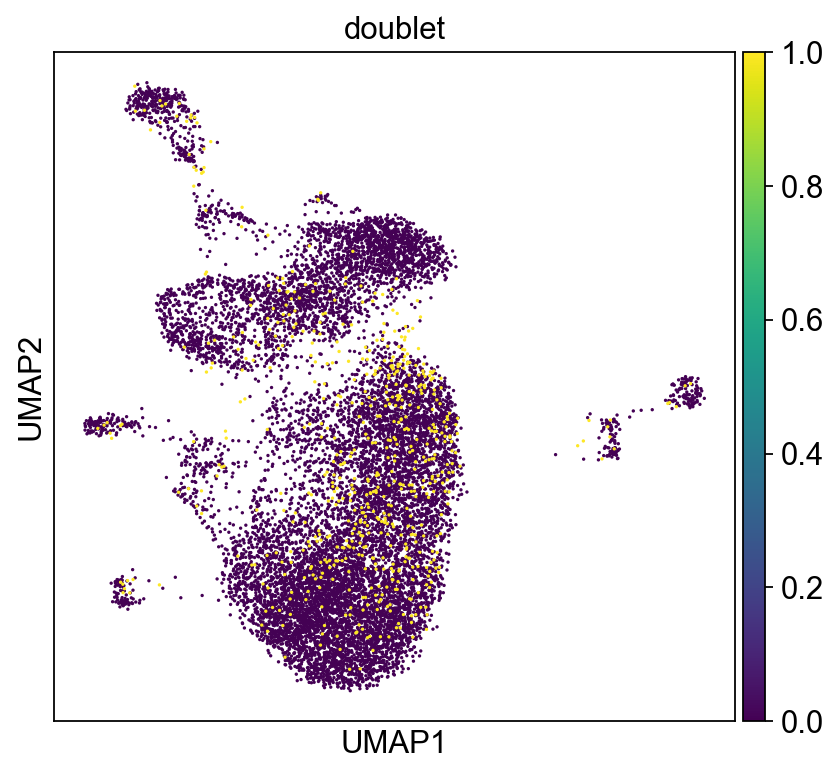

In [40]:
rcParams['figure.figsize'] = 6, 5.5
sc.pl.umap(bdata, color=['doublet'])

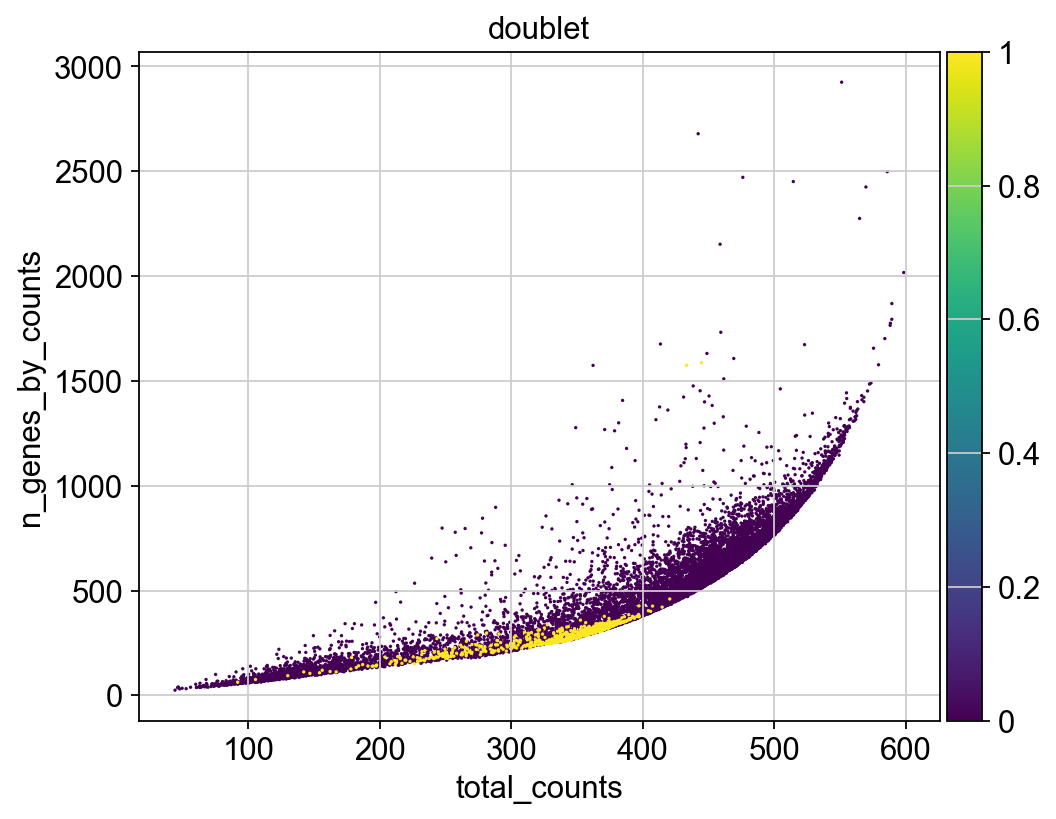

In [41]:
sc.pl.scatter(bdata, 'total_counts', 'n_genes_by_counts', color='doublet')

### Exporting New Doublets

In [46]:
bdata_dbl = bdata.obs["scDblFinder_class"] == 'doublet'
bdata_dbl = bdata.obs_names[bdata_dbl]

In [47]:
with open("./results/scDblFinder_exp_sc85_1g_ids.txt", "w") as txt_file:
    for cell in bdata_dbl:
        txt_file.write(cell + "\n")